In [1]:
import os
import gc
import torch
os.chdir("/work/pi_jensen_umass_edu/jnainani_umass_edu/CircuitAnalysisSAEs")
import json
from sae_lens import SAE, HookedSAETransformer
from circ4latents import data_gen
from functools import partial
import einops

# Function to manage CUDA memory and clean up
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()
# cleanup_cuda()
# Load the config
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token


# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache


# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache)


Device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [2]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Nov 27 17:53:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:84:00.0 Off |                    0 |
| N/A   35C    P0             69W /  400W |   42711MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# layers= [7, 14, 21, 28, 40]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_21/width_16k/average_l0_129", device=device)[0]]

In [4]:

import json
import random

# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]

for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"

# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{correct_name}"]\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        
        # Create an incorrect example with a name not in the dictionary
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{incorrect_name}"]\n'
        incorrect_response = "Traceback"
        incorrect_token = "Traceback"
        
        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
        
    return dataset

# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=100)
json_dataset[0]['correct']['prompt']

'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {\'Jackson\': 13, \'Chris\': 11, \'Jake\': 11, \'Oliver\': 18, \'Lucas\': 11}\n>>> age["Chris"]\n'

In [5]:
clean_prompts = []
corr_prompts = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset[:50]:
    corr_prompts.append(item["correct"]["prompt"])
    clean_prompts.append(item["error"]["prompt"])

clean_tokens = model.to_tokens(clean_prompts)
corr_tokens = model.to_tokens(corr_prompts)

def logit_diff_fn(logits):
    err = logits[:, -1, traceback_token]
    no_err = logits[:, -1, answer_token]
    return (err - no_err).mean()

# Disable gradients for all parameters
for param in model.parameters():
   param.requires_grad_(False)

logits = model(clean_tokens)
clean_diff = logit_diff_fn(logits)

logits = model(corr_tokens)
corr_diff = logit_diff_fn(logits)

print(f"clean_diff: {clean_diff}")
print(f"corr_diff: {corr_diff}")

# # Cleanup
del logits
cleanup_cuda()

# # Define error type metric
def _err_type_metric(logits, clean_logit_diff, corr_logit_diff):
    patched_logit_diff = logit_diff_fn(logits)
    return (patched_logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)

err_metric_denoising = partial(_err_type_metric, clean_logit_diff=clean_diff, corr_logit_diff=corr_diff)

clean_diff: 7.077381610870361
corr_diff: -6.983396053314209


In [6]:
with open('mask_finding/mask.json') as f:
    mask = json.load(f)
len(mask['blocks.21.hook_resid_post'])

192

In [7]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch_mean(new_tokens, filtered_ids, model, saes, mean_cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in mean_cache and hook.name in dict_feats:
               prev_sae = mean_cache[hook.name]  # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx not in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits


def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name]  # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits


# def run_with_saes_latent_op_patch_zero(new_tokens, filtered_ids, model, saes, dict_feats):
#    # Ensure tokens are a torch.Tensor
#    if not isinstance(new_tokens, torch.Tensor):
#        new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

#    # Create a mask where True indicates positions to modify
#    mask = torch.ones_like(new_tokens, dtype=torch.bool)
#    for token_id in filtered_ids:
#        mask &= new_tokens != token_id

#    # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
#    mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
#    mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
#    # For each SAE, add the appropriate hook
#    for sae in saes:
#        hook_point = sae.cfg.hook_name

#        # Define the filtered hook function (optimized)
#        def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
#            # Apply the SAE only where mask_expanded is True
#            enc_sae = sae.encode(act)  # Call the SAE once
          
#            if hook.name in dict_feats:
#                feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

#                for feature_idx in range(sae.cfg.d_sae):
#                    if feature_idx not in feature_indices:
#                        enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

#            # After patching, decode the modified enc_sae
#            modified_act = sae.decode(enc_sae)

#            # In-place update where the mask is True
#            updated_act = torch.where(mask_expanded, modified_act, act)

#            return updated_act

#        # Add the hook to the model
#        model.add_hook(hook_point, filtered_hook, dir='fwd')

#    # Run the model with the tokens (no gradients needed)
#    with torch.no_grad():
#        logits = model(new_tokens)

#    # Reset the hooks after computation to free memory
#    model.reset_hooks()

#    return logits  # Return only the logits

In [9]:
model.reset_hooks()
filtered_ids = [model.tokenizer.bos_token_id]
clean_sae_logits, clean_sae_cache = run_with_saes_filtered_cache(clean_tokens, filtered_ids, model, saes)
corr_sae_logits, corr_sae_cache = run_with_saes_filtered_cache(corr_tokens, filtered_ids, model, saes)

clean_sae_diff = logit_diff_fn(clean_sae_logits)
corr_sae_diff = logit_diff_fn(corr_sae_logits)

print(f"clean_sae_diff: {clean_sae_diff}")
print(f"corr_sae_diff: {corr_sae_diff}")

# Cleanup
del clean_sae_logits, corr_sae_logits
cleanup_cuda()

clean_sae_diff: 3.0971879959106445
corr_sae_diff: -5.324131965637207


In [15]:

corr_sae_cache_means = {layer: sae_cache.mean(dim=0) for layer, sae_cache in corr_sae_cache.items()}

print(corr_sae_cache['blocks.21.hook_resid_post'].shape)
print(corr_sae_cache_means['blocks.21.hook_resid_post'].shape)

torch.Size([50, 65, 16384])
torch.Size([65, 16384])


In [11]:
dict_feats = {"blocks.21.hook_resid_post": mask['blocks.21.hook_resid_post']}

In [16]:
model.reset_hooks()
logits = run_with_saes_latent_op_patch_mean(clean_tokens, filtered_ids=filtered_ids, model=model, saes=saes,mean_cache=corr_sae_cache_means,dict_feats=dict_feats)
mean_diff = logit_diff_fn(logits)
print(f"recovered diff: {mean_diff}")

recovered diff: -2.7929320335388184


In [17]:
model.reset_hooks()
logits = run_with_saes_zero_ablation(clean_tokens, filtered_ids, model, saes, mask)
clean_sae_diff_ablation = logit_diff_fn(logits)
print(f"clean_sae_diff_ablation: {clean_sae_diff_ablation}")

logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
corr_sae_diff_ablation = logit_diff_fn(logits)
print(f"corr_sae_diff_ablation: {corr_sae_diff_ablation}")

# Cleanup
del logits
cleanup_cuda()

clean_sae_diff_ablation: 0.24259696900844574
corr_sae_diff_ablation: -3.2401013374328613


In [20]:
from tqdm import tqdm
total_steps = sum([len(latents) for latents in dict_feats.values()])
print(f"Total steps: {total_steps}")

Total steps: 192


In [21]:

denoising_results = {}
with tqdm(total=total_steps, desc="Denoising Progress") as pbar:
   for layer, latents in dict_feats.items():
      # print(f"Layer: {layer}")
      denoising_results[layer] = {}
      for latent in latents:
         # print(f"Latent: {latent}")
         filtered_ids = [model.tokenizer.bos_token_id] 
         small_dict = {layer: [latent]}
         logits = run_with_saes_latent_op_patch(corr_tokens, filtered_ids, model, saes, clean_sae_cache, small_dict)
         patched_err_metric = logit_diff_fn(logits)
         normalized_metric = (patched_err_metric - corr_sae_diff) / (clean_sae_diff - corr_sae_diff)
         denoising_results[layer][latent] = normalized_metric.detach().cpu().item()
         pbar.update(1)
denoising_results

Denoising Progress: 100%|██████████| 192/192 [11:09<00:00,  3.49s/it]


{'blocks.21.hook_resid_post': {13: 0.0,
  43: 2.542355468904134e-05,
  52: 0.007228556089103222,
  406: -0.00018860993441194296,
  520: 0.0,
  534: 0.008642706088721752,
  576: 0.0,
  712: 1.081491973309312e-05,
  718: 0.0008580024586990476,
  722: -0.000279998843325302,
  824: 0.0,
  918: 0.0006185454549267888,
  1374: -0.00027314748149365187,
  1408: 0.01332460343837738,
  1662: 0.0,
  1723: 0.0,
  1744: 0.005711919628083706,
  1831: -0.001618387526832521,
  1942: 0.0,
  1967: -0.0007185409776866436,
  2054: 0.0033187081571668386,
  2123: -0.0022685283329337835,
  2239: 0.00014382143854163587,
  2293: 0.0,
  2442: 0.0005006005521863699,
  2445: 0.0,
  2502: 0.0,
  2739: 0.005264148116111755,
  2899: 0.0,
  2916: 0.00028362267767079175,
  2919: 0.0019345682812854648,
  2957: 0.00577482720836997,
  3002: 0.0,
  3018: 0.001636959845200181,
  3023: -0.0003234850009903312,
  3076: 0.018683085218071938,
  3129: -0.0005667923833243549,
  3186: 0.00013663037680089474,
  3261: 0.0,
  3357: 0.

In [25]:
# save denoising results as pickle 
import pickle
with open('mask_finding/out/maskVattr/denoising_results.pkl', 'wb') as f:
    pickle.dump(denoising_results, f)

In [28]:
# subtract element 13 from the mask list
mask['blocks.21.hook_resid_post'] 

In [35]:
new_mask = [latent for latent in range(saes[0].cfg.d_sae) if latent != 13]

In [40]:
small_dict = {'blocks.21.hook_resid_post': [latentdash for latentdash in range(saes[0].cfg.d_sae)]}
feature_indices = small_dict['blocks.21.hook_resid_post']

In [42]:
feature_indices = [13]

In [44]:
all_indices = torch.arange(saes[0].cfg.d_sae, device=model.cfg.device)
zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
zero_indices[:20]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
        19, 20], device='cuda:0')

In [46]:
small_dict = {'blocks.21.hook_resid_post': []}
logits = run_with_saes_zero_ablation(clean_tokens, filtered_ids, model, saes, small_dict)
all_zero_metric = logit_diff_fn(logits)
print(f"patched_err_metric: {all_zero_metric}")

patched_err_metric: -10.46799087524414


In [47]:
zero_patching_results = {}
with tqdm(total=total_steps, desc="Zero Patching Progress") as pbar:
   for layer, latents in dict_feats.items():
      # print(f"Layer: {layer}")
      zero_patching_results[layer] = {}
      for latent in latents:
         # print(f"Latent: {latent}")
         filtered_ids = [model.tokenizer.bos_token_id] 
         small_dict = {layer: [latent]}
         logits = run_with_saes_zero_ablation(clean_tokens, filtered_ids, model, saes, small_dict)
         patched_err_metric = logit_diff_fn(logits)
         normalized_metric = (patched_err_metric - all_zero_metric) / (clean_sae_diff - all_zero_metric)
         zero_patching_results[layer][latent] = normalized_metric.detach().cpu().item()
         pbar.update(1)
zero_patching_results

Zero Patching Progress:  99%|█████████▉| 191/192 [11:05<00:03,  3.49s/it]


{'blocks.21.hook_resid_post': {43: 0.000901356223039329,
  52: 0.006587120704352856,
  406: 0.005280185490846634,
  520: 0.003349591977894306,
  534: -0.00032409734558314085,
  576: 0.000757445755880326,
  712: 1.0123648280568887e-05,
  718: -6.060128362150863e-05,
  722: 0.008530087769031525,
  824: -0.0006650674622505903,
  918: 0.017690934240818024,
  1374: 0.002812265185639262,
  1408: 0.00889123510569334,
  1662: 0.0,
  1723: 0.0,
  1744: -0.000971940578892827,
  1831: 0.0014968236209824681,
  1942: -0.0013574125478044152,
  1967: 0.024337179958820343,
  2054: 0.021733716130256653,
  2123: 0.023375222459435463,
  2239: 0.0007033123401924968,
  2293: -0.0003792149946093559,
  2442: -0.0028957852628082037,
  2445: 1.1178195563843474e-05,
  2502: 0.00022032996639609337,
  2739: -0.0010361976455897093,
  2899: -4.6470358938677236e-05,
  2916: 0.005340998061001301,
  2919: -0.011980142444372177,
  2957: 0.00977656152099371,
  3002: 0.008027350530028343,
  3018: -0.005249814596027136,
 

In [48]:
# save the zero patching results as pickle
with open('mask_finding/out/maskVattr/zero_patching_results.pkl', 'wb') as f:
    pickle.dump(zero_patching_results, f)

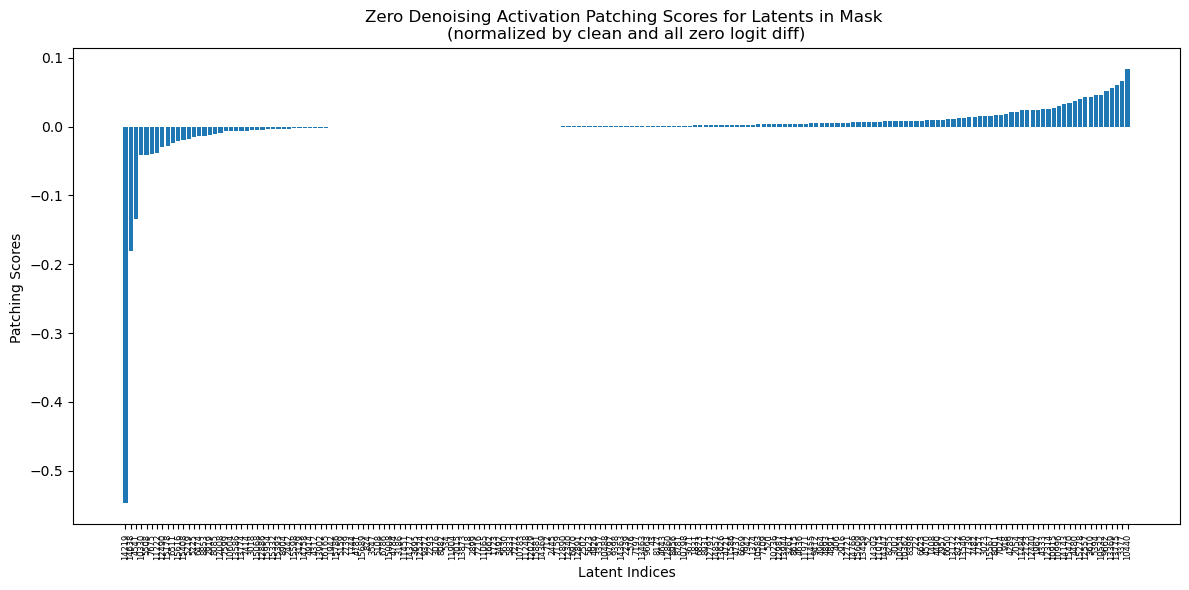

In [53]:
import matplotlib.pyplot as plt
# Sorting the dictionaries by their values
# sorted_dict1 = dict(sorted(.items(), key=lambda item: item[1]))

# Convert keys to strings and sort by values for the first dictionary
sorted_dict1_str = dict(sorted({str(k): v for k, v in zero_patching_results['blocks.21.hook_resid_post'].items()}.items(), key=lambda item: item[1]))

# Plotting the updated first dictionary
plt.figure(figsize=(12, 6))
plt.bar(sorted_dict1_str.keys(), sorted_dict1_str.values())
plt.title("Zero Denoising Activation Patching Scores for Latents in Mask \n(normalized by clean and all zero logit diff)")
plt.xlabel("Latent Indices")
plt.ylabel("Patching Scores ")
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()


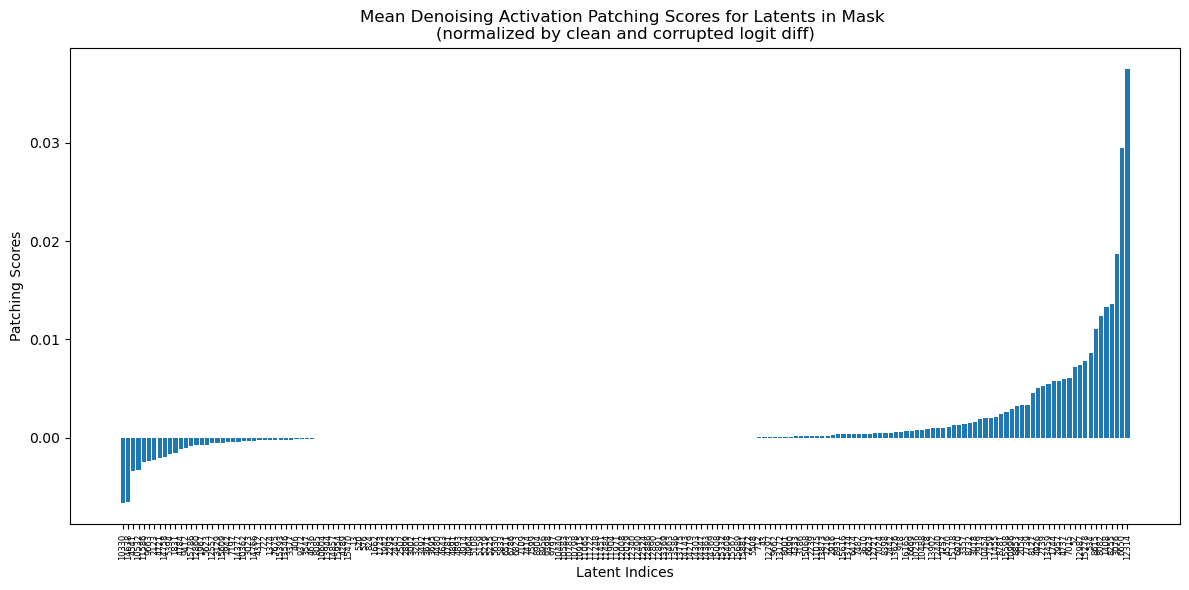

In [54]:
import matplotlib.pyplot as plt
# Sorting the dictionaries by their values
# sorted_dict1 = dict(sorted(.items(), key=lambda item: item[1]))

# Convert keys to strings and sort by values for the first dictionary
sorted_dict1_str = dict(sorted({str(k): v for k, v in denoising_results['blocks.21.hook_resid_post'].items()}.items(), key=lambda item: item[1]))

# Plotting the updated first dictionary
plt.figure(figsize=(12, 6))
plt.bar(sorted_dict1_str.keys(), sorted_dict1_str.values())
plt.title("Mean Denoising Activation Patching Scores for Latents in Mask \n(normalized by clean and corrupted logit diff)")
plt.xlabel("Latent Indices")
plt.ylabel("Patching Scores")
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()


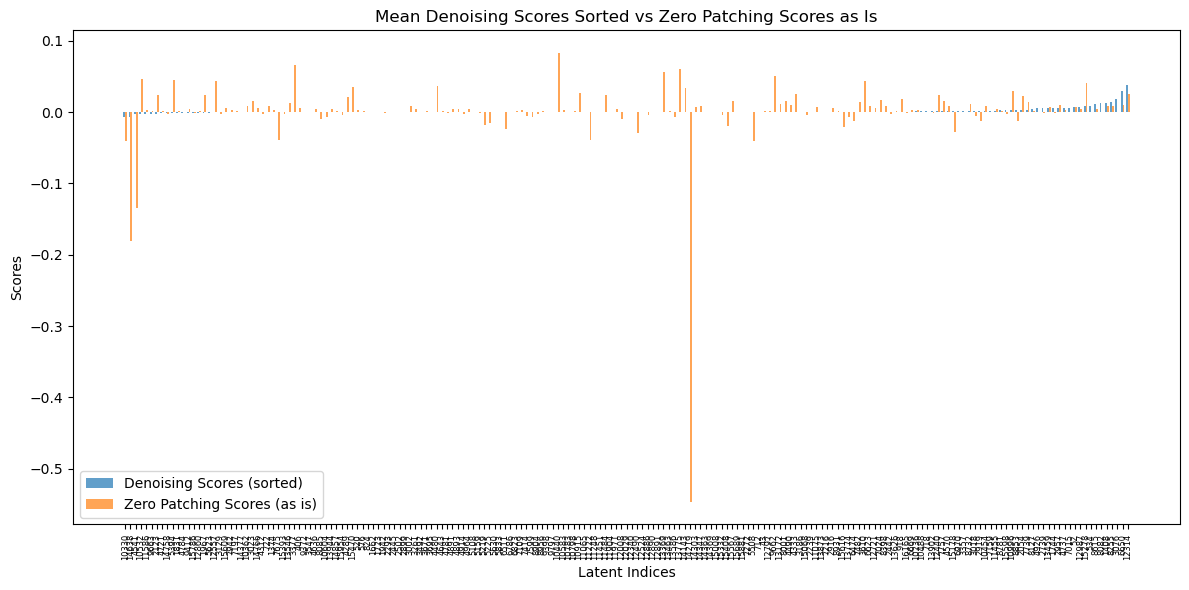

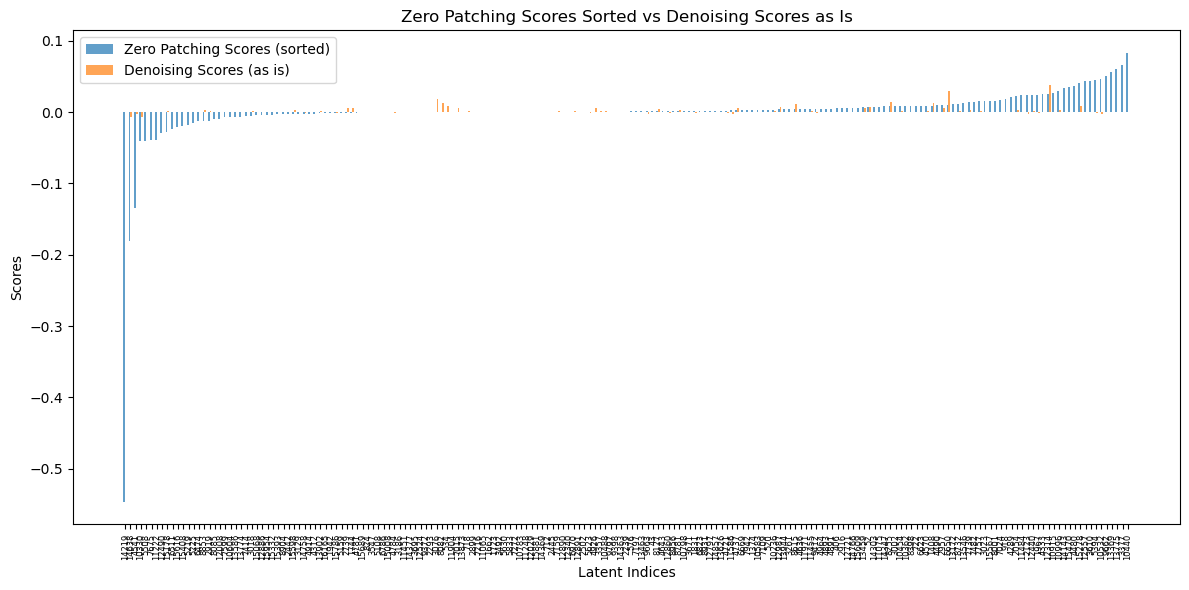

In [71]:
# Plotting with two bars side by side for each latent index

# Convert keys to strings and sort one dictionary
denoising_sorted = dict(sorted({str(k): v for k, v in denoising_results['blocks.21.hook_resid_post'].items() if k!=13}.items(), key=lambda item: item[1]))
zero_patching_as_is = {str(k): zero_patching_results['blocks.21.hook_resid_post'][int(k)] for k in denoising_sorted.keys()}

# Convert keys to strings and sort the other dictionary
zero_patching_sorted = dict(sorted({str(k): v for k, v in zero_patching_results['blocks.21.hook_resid_post'].items()}.items(), key=lambda item: item[1]))
denoising_as_is = {str(k): denoising_results['blocks.21.hook_resid_post'][int(k)] for k in zero_patching_sorted.keys()}



# First case: Denoising scores sorted, zero-patching scores as is
plt.figure(figsize=(12, 6))
bar_width = 0.35
indices = range(len(denoising_sorted))

plt.bar(
    [i - bar_width / 2 for i in indices],
    denoising_sorted.values(),
    width=bar_width,
    label="Denoising Scores (sorted)",
    alpha=0.7
)
plt.bar(
    [i + bar_width / 2 for i in indices],
    zero_patching_as_is.values(),
    width=bar_width,
    label="Zero Patching Scores (as is)",
    alpha=0.7
)

plt.title("Mean Denoising Scores Sorted vs Zero Patching Scores as Is")
plt.xlabel("Latent Indices")
plt.ylabel("Scores")
plt.xticks(indices, denoising_sorted.keys(), rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()

# Second case: Zero-patching scores sorted, denoising scores as is
plt.figure(figsize=(12, 6))

indices = range(len(zero_patching_sorted))

plt.bar(
    [i - bar_width / 2 for i in indices],
    zero_patching_sorted.values(),
    width=bar_width,
    label="Zero Patching Scores (sorted)",
    alpha=0.7
)
plt.bar(
    [i + bar_width / 2 for i in indices],
    denoising_as_is.values(),
    width=bar_width,
    label="Denoising Scores (as is)",
    alpha=0.7
)

plt.title("Zero Patching Scores Sorted vs Denoising Scores as Is")
plt.xlabel("Latent Indices")
plt.ylabel("Scores")
plt.xticks(indices, zero_patching_sorted.keys(), rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Nov 27 17:28:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:84:00.0 Off |                    0 |
| N/A   36C    P0             69W /  400W |   47107MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [8]:
cleanup_cuda()

## Attr time

In [9]:
from transformer_lens import ActivationCache, utils
from transformer_lens.hook_points import HookPoint
# from torchtyping import TensorType as TT

def get_cache_fwd_and_bwd(
    model,
    tokens,
    metric,
    sae,
    error_term: bool = True,
    retain_graph: bool = True
):
    # torch.set_grad_enabled(True)
    model.reset_hooks()
    # model.reset_saes()
    cache = {}
    grad_cache = {}
    filter_base_acts = lambda name: "blocks.21.hook_resid_post" in name
    # filter_sae_acts = lambda name: "hook_sae_acts_post" in name

    def forward_cache_hook(act, hook):
        act.requires_grad_(True)
        # act.retain_graph()
        cache[hook.name] = act.detach()

    def backward_cache_hook(grad, hook):
        grad.requires_grad_(True)
        # grad.retain_graph()
        grad_cache[hook.name] = grad.detach()

    # sae.use_error_term = error_term
    # model.add_sae(sae)
    model.add_hook(filter_base_acts, forward_cache_hook, "fwd")
    model.add_hook(filter_base_acts, backward_cache_hook, "bwd")
    # logits = run_with_saes_filtered(tokens, [model.tokenizer.bos_token_id, model.tokenizer.eos_token_id, model.tokenizer.pad_token_id], model, [sae])
    value = metric(model(tokens)) #logits)
    value.backward() #retain_graph=retain_graph)

    model.reset_hooks()
    # model.reset_saes()
    # torch.set_grad_enabled(False)
    return (
        value,
        ActivationCache(cache, model),
        ActivationCache(grad_cache, model),
    )

clean_value, clean_cache, _ = get_cache_fwd_and_bwd(model, clean_tokens, err_metric_denoising, saes)
print("Clean Value:", clean_value)
print("Clean Activations Cached:", len(clean_cache))
# print("Clean Gradients Cached:", len(clean_grad_cache))

corrupted_value, corrupted_cache, corrupted_grad_cache = get_cache_fwd_and_bwd(model, corr_tokens, err_metric_denoising, saes)
print("Corrupted Value:", corrupted_value)
print("Corrupted Activations Cached:", len(corrupted_cache))
print("Corrupted Gradients Cached:", len(corrupted_grad_cache))

# # Cleanup
del clean_value, corrupted_value
cleanup_cuda()

KeyboardInterrupt: 

In [76]:
sae_acts = saes[0].encode(clean_cache['blocks.21.hook_resid_post'][:, 1:, :])
sae_acts_corr = saes[0].encode(corrupted_cache['blocks.21.hook_resid_post'][:, 1:, :])
print(sae_acts.shape, sae_acts_corr.shape)

sae_grad_cache = torch.einsum('bij,kj->bik', corrupted_grad_cache['blocks.21.hook_resid_post'][:, 1:, :], saes[0].W_dec)
print(sae_grad_cache.shape)

torch.Size([50, 64, 16384]) torch.Size([50, 64, 16384])
torch.Size([50, 64, 16384])


In [77]:
K = 100
# Residual attribution calculation only for the selected positions
residual_attr_final = einops.reduce(
    sae_grad_cache * (sae_acts - sae_acts_corr),
    "batch pos n_features -> n_features",
    "sum",
)
# Get the top K features based on the absolute values
abs_residual_attr_final = torch.abs(residual_attr_final)
top_feats = torch.topk(abs_residual_attr_final, K)
top_indices = top_feats.indices
top_values = residual_attr_final[top_indices] 
print(top_indices, top_values)

tensor([12314,  6650,  1275,  4628, 11135, 10824,   357,  1408, 12987,  3076,
         8615, 10988,  8255, 14515,  7762, 11416,  4729,  4210,  7739,  8127,
         3908,  1744,  8082,  6616,  9204,   718, 13459,  1983, 11890, 13511,
        15755, 15549,  9551, 11407,  8185,  4737, 13301,  2957,  3216,  4994,
         1426,  2020,  9734, 10340,  8853,  9458, 10330, 15278, 10003, 10520,
        10603, 15001, 14958,   534,  2054,  6433,  9587, 10532, 13295,  2270,
        13776, 13020,  2739,  8781, 15460,  3272, 12151,  5394,  1197,  6669,
         2332, 14850,  1357,  1605,  7597, 10996, 15546,  7675, 13495,  4926,
         7015,  7482, 12758,  3433, 13061,    52,  5066, 13953,  6740,  9663,
        10367,  5930,   846,  3278,  3127,  5185, 12507,  7717, 11547,  1831],
       device='cuda:0') tensor([ 0.0359,  0.0287,  0.0146,  0.0134,  0.0106,  0.0106,  0.0084,  0.0082,
         0.0081,  0.0080,  0.0078,  0.0076,  0.0074,  0.0073,  0.0067,  0.0058,
         0.0056, -0.0053,  0.0047, 

In [78]:
abs_residual_attr_final.

torch.Size([16384])

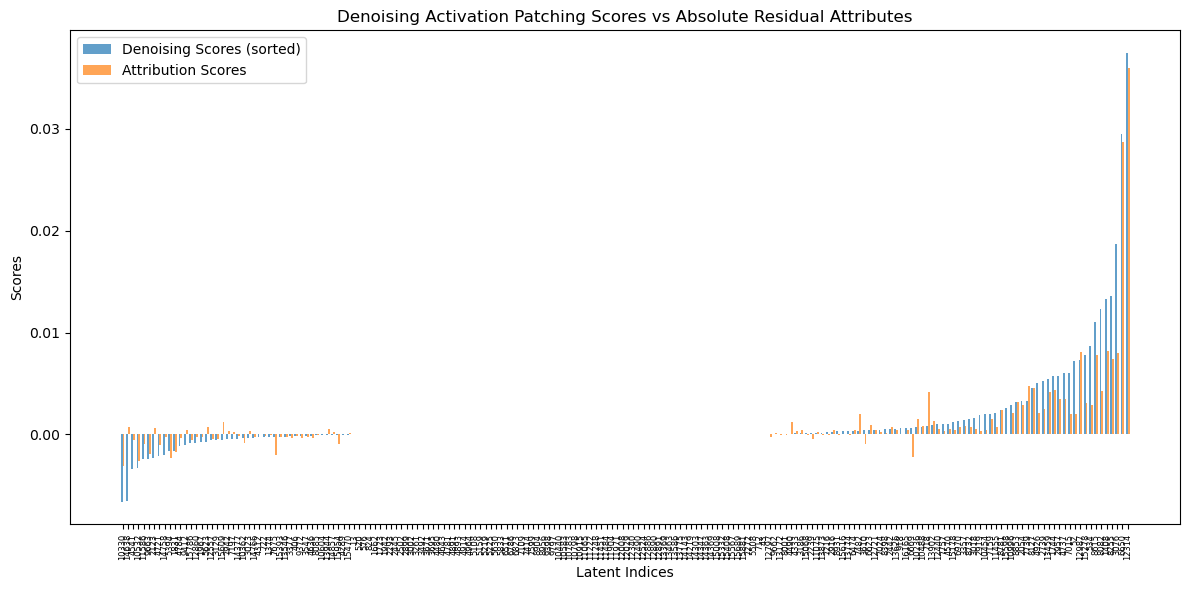

In [81]:
# Assuming `abs_residual_attr_final` is a dictionary or list-like structure with 16k elements
# Replace this placeholder with your actual data structure
# abs_residual_attr_final = {i: i / 10000.0 for i in range(16000)}

# Convert keys to strings and sort by values for the denoising dictionary
sorted_dict1_str = dict(
    sorted(
        {str(k): v for k, v in denoising_results['blocks.21.hook_resid_post'].items()}.items(),
        key=lambda item: item[1],
    )
)

# Extract values from `abs_residual_attr_final` for the sorted keys
abs_residual_values = {
    k: residual_attr_final[int(k)].cpu().item() for k in sorted_dict1_str.keys()
}

# Plotting the updated single bar plot with two columns
plt.figure(figsize=(12, 6))
bar_width = 0.35
indices = range(len(sorted_dict1_str))

plt.bar(
    [i - bar_width / 2 for i in indices],
    sorted_dict1_str.values(),
    width=bar_width,
    label="Denoising Scores (sorted)",
    alpha=0.7,
)
plt.bar(
    [i + bar_width / 2 for i in indices],
    abs_residual_values.values(),
    width=bar_width,
    label="Attribution Scores",
    alpha=0.7,
)

plt.title("Denoising Activation Patching Scores vs Absolute Residual Attributes")
plt.xlabel("Latent Indices")
plt.ylabel("Scores")
plt.xticks(indices, sorted_dict1_str.keys(), rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
clean_value, clean_cache, clean_grad_cache = get_cache_fwd_and_bwd(model, clean_tokens, err_metric_denoising, saes)
print("Clean Value:", clean_value)
print("Clean Activations Cached:", len(clean_cache))
print("Clean Gradients Cached:", len(clean_grad_cache))

Clean Value: tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Clean Activations Cached: 1
Clean Gradients Cached: 1


In [ ]:
sae_acts = saes[0].encode(clean_cache['blocks.21.hook_resid_post'][:, 1:, :])
sae_grad_cache = torch.einsum('bij,kj->bik', clean_grad_cache['blocks.21.hook_resid_post'][:, 1:, :], saes[0].W_dec)
print(sae_grad_cache.shape)


In [ ]:
K = 100
# Residual attribution calculation only for the selected positions
residual_attr_final = einops.reduce(
    sae_grad_cache * (sae_acts - sae_acts_corr),
    "batch pos n_features -> n_features",
    "sum",
)
# Get the top K features based on the absolute values
abs_residual_attr_final = torch.abs(residual_attr_final)
top_feats = torch.topk(abs_residual_attr_final, K)
top_indices = top_feats.indices
top_values = residual_attr_final[top_indices] 
print(top_indices, top_values)

In [70]:
denoising_sorted = dict(sorted({str(k): v for k, v in denoising_results['blocks.21.hook_resid_post'].items() if k!=13}.items(), key=lambda item: item[1]))
denoising_sorted['13']

KeyError: '13'

In [69]:
denoising_sorted['13']

0.0

In [61]:
denoising_sorted_skip_first

{'14638': -0.006565,
 '4541': -0.00336,
 '10532': -0.003271,
 '11586': -0.002447,
 '9663': -0.002396,
 '2123': -0.002268,
 '4721': -0.002083,
 '14758': -0.002026,
 '5394': -0.001662,
 '1831': -0.001618,
 '4784': -0.001124,
 '9412': -0.001086,
 '15786': -0.0008774,
 '12860': -0.000794,
 '1967': -0.0007186,
 '5623': -0.000707,
 '12557': -0.0005717,
 '3129': -0.000567,
 '15609': -0.0005264,
 '7942': -0.000443,
 '7197': -0.000434,
 '14377': -0.000401,
 '10362': -0.0003712,
 '3023': -0.0003235,
 '14766': -0.0003226,
 '4312': -0.0002835,
 '722': -0.00028,
 '1374': -0.0002732,
 '7675': -0.0002414,
 '15393': -0.0002363,
 '13546': -0.0002265,
 '3377': -0.0001998,
 '406': -0.0001886,
 '9372': -0.0001805,
 '3547': -0.0001281,
 '4636': -0.00011826,
 '8085': -7.21e-05,
 '10604': -4.166e-05,
 '13944': -2.67e-05,
 '14857': -2.45e-05,
 '15954': -1.53e-05,
 '4289': -1.31e-05,
 '15470': -1.13e-05,
 '13': 0.0,
 '520': 0.0,
 '576': 0.0,
 '824': 0.0,
 '1662': 0.0,
 '1723': 0.0,
 '1942': 0.0,
 '2293': 0.0,


In [60]:
list(denoising_results['blocks.21.hook_resid_post'].keys())

[13,
 43,
 52,
 406,
 520,
 534,
 576,
 712,
 718,
 722,
 824,
 918,
 1374,
 1408,
 1662,
 1723,
 1744,
 1831,
 1942,
 1967,
 2054,
 2123,
 2239,
 2293,
 2442,
 2445,
 2502,
 2739,
 2899,
 2916,
 2919,
 2957,
 3002,
 3018,
 3023,
 3076,
 3129,
 3186,
 3261,
 3357,
 3377,
 3492,
 3547,
 3610,
 3671,
 3695,
 4289,
 4312,
 4333,
 4480,
 4490,
 4541,
 4570,
 4636,
 4643,
 4721,
 4737,
 4781,
 4784,
 4891,
 4893,
 4914,
 4926,
 4964,
 5108,
 5159,
 5219,
 5225,
 5394,
 5508,
 5623,
 5630,
 5833,
 6474,
 6511,
 6623,
 6650,
 6669,
 6786,
 6823,
 6970,
 7015,
 7024,
 7109,
 7159,
 7197,
 7216,
 7272,
 7414,
 7482,
 7599,
 7675,
 7739,
 7757,
 7942,
 8001,
 8082,
 8085,
 8127,
 8255,
 8398,
 8615,
 8732,
 8781,
 8853,
 8904,
 8931,
 8956,
 9372,
 9398,
 9412,
 9662,
 9663,
 9797,
 10236,
 10330,
 10362,
 10440,
 10454,
 10488,
 10532,
 10583,
 10604,
 10783,
 10798,
 10915,
 10996,
 11065,
 11075,
 11222,
 11248,
 11451,
 11455,
 11484,
 11586,
 11904,
 11971,
 12008,
 12029,
 12314,
 12340,
 